# Automatic Care Symbol Detection (YOLO)

In [ ]:
# make sure all dependencies are installed
!pip install ultralytics Pillow matplotlib ipython

In [ ]:
from ultralytics import YOLO
from PIL import ImageFont, ImageDraw, Image
import matplotlib.font_manager as fm
from IPython.display import display

In [2]:
# load model
model = YOLO("./model.pt")

In [17]:
image_path = "./sample_image.jpg" # enter image path here

In [18]:
image = Image.open(image_path)

In [19]:
# predict boxes and confidence scores
results = model(image_path)


image 1/1 /Users/athul/Library/Mobile Documents/com~apple~CloudDocs/Courses/CSE 6367 Computer Vision/Project/Github/Final Product/sample_image.jpg: 640x640 1 40C, 1 DN_bleach, 2 DN_dry_cleans, 1 DN_tumble_dry, 1 iron_low, 1 iron_medium, 282.7ms
Speed: 1.9ms preprocess, 282.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


In [20]:
# function to draw bounding boxes 
def draw_YOLO_boxes(image_pil, results, confidence_threshold=0.75):
    image_pil = image_pil.convert("RGBA")
    draw = ImageDraw.Draw(image_pil)
    font_path = fm.findfont("DejaVu Sans")
    font_box = ImageFont.truetype(font_path, 20)
    font_legend = ImageFont.truetype(font_path, 20)

    box_color = (255, 0, 0, 255)       # Red
    text_color = (255, 255, 255, 255)  # White
    detected_classes = set()

    # Extract bounding boxes, confidence scores, and class IDs from YOLO results
    boxes = [box.xyxy[0].cpu().numpy() for box in results[0].boxes]
    scores = [box.conf[0].item() for box in results[0].boxes]
    class_ids = [int(box.cls[0].item()) for box in results[0].boxes]

    # Draw bounding boxes and labels
    for box, cls_id, score in zip(boxes, class_ids, scores):
        # filter out low-confidence boxes
        if score < confidence_threshold:
            continue

        x1, y1, x2, y2 = map(int, box)
        cls_int = int(cls_id)
        label = f"{cls_int}"
        detected_classes.add(cls_int)

        draw.rectangle([x1, y1, x2, y2], outline=box_color, width=3)

        # Draw label background and text
        text_size = draw.textbbox((0, 0), label, font=font_box)
        w, h = text_size[2] - text_size[0], text_size[3] - text_size[1]
        pad = 2
        draw.rectangle([x1, y1 - h - 2 * pad, x1 + w + 2 * pad, y1], fill=box_color)
        draw.text((x1 + pad, y1 - h - 2*pad), label, font=font_box, fill=text_color)
    
    if len(detected_classes) == 0:
        print("No symbols were detected!")
        return image_pil

    # Create transparent legend for detected classes
    sorted_classes = sorted(detected_classes)
    legend_texts = [f"{i}: {model.names[i]}" for i in sorted_classes]
    line_height = font_legend.getbbox("Ay")[3] + 6
    padding = 6
    legend_width = max(ImageDraw.Draw(Image.new("RGB", (1, 1))).textlength(t, font=font_legend) for t in legend_texts) + 2 * padding
    legend_height = len(legend_texts) * line_height + 2 * padding
    start_x = 10
    start_y = image_pil.height - legend_height - 10

    overlay = Image.new("RGBA", image_pil.size, (0, 0, 0, 0))
    draw_overlay = ImageDraw.Draw(overlay)
    draw_overlay.rectangle([start_x, start_y, start_x + legend_width, start_y + legend_height],
                           fill=(0, 0, 0, 180))
    for i, cls_id in enumerate(sorted_classes):
        text = f"{cls_id}: {model.names[cls_id]}"
        y = start_y + padding + i * line_height
        draw_overlay.text((start_x + padding, y), text, font=font_legend, fill=(255, 255, 0, 255))

    image_pil = Image.alpha_composite(image_pil, overlay)

    return image_pil


# call function
annotated_image = draw_YOLO_boxes(image, results)

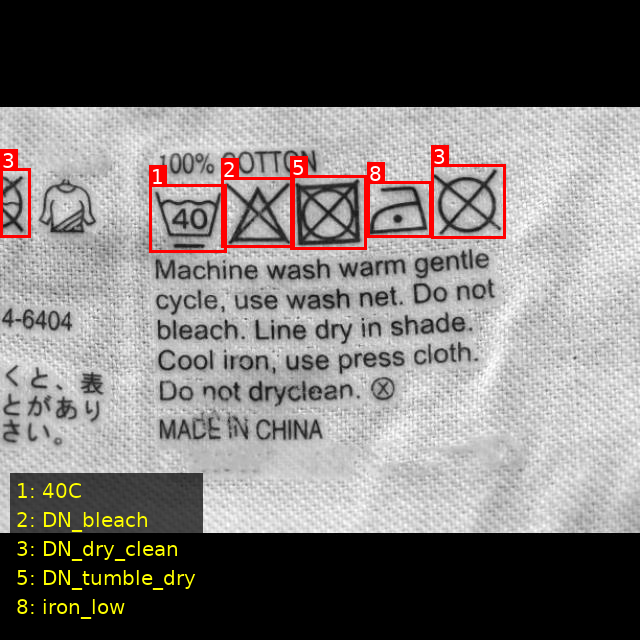

In [21]:
# display annotated image
display(annotated_image)